In [ ]:
!nvidia-smi

# Going Modular

Writing commonly used tasks to python scripts for modularity use.

## Imports and constants

In [2]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from torchvision import transforms

In [4]:
BATCH_SIZE = 32
NUM_WORKERS = int((os.cpu_count() + 1) / 2)

image_path = Path("../inputs/") / "pizza_steak_sushi"

## Get Data

In [5]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('../inputs/pizza_steak_sushi/train'),
 PosixPath('../inputs/pizza_steak_sushi/test'))

## Dataloader and Datasets

In [76]:
%%writefile ../src/data_setup.py
"""
Custom DataLoader module for image classification using PyTorch.

This module provides a `CustomDataloader` class that simplifies 
loading image datasets for training and testing.

Example Usage:
    dataloader = CustomDataloader(train_dir="path/to/train",
                                  test_dir="path/to/test",
                                  transform=some_transform)
    
    train_loader, test_loader = dataloader.get_dataloaders()
    class_names = dataloader.classes
"""

import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import random
import torch
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

# Default batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = max(1, os.cpu_count() // 2)  # Ensure at least 1 worker

class CustomDataloader:
    """
    Custom DataLoader class for image classification datasets.

    This class loads training and testing datasets from directories,
    applies transformations, and creates PyTorch DataLoaders.

    Attributes
    ----------
    classes : list
        List of class names in the dataset.
    class_to_idx : dict
        Mapping of class names to indices.
    train_dataloader : DataLoader
        DataLoader for the training dataset.
    test_dataloader : DataLoader
        DataLoader for the testing dataset.

    Methods
    -------
    get_dataloaders():
        Returns both train and test DataLoaders as a tuple.
    """

    def __init__(self, train_dir: str, test_dir: str, transform: transforms.Compose = None,
                 batch_size: int = BATCH_SIZE, num_workers: int = NUM_WORKERS, transform_test_data: bool = False):
        """
        Initializes the CustomDataloader with specified parameters.

        Parameters
        ----------
        train_dir : str
            Path to the training dataset directory.
        test_dir : str
            Path to the testing dataset directory.
        transform : torchvision.transforms.Compose, optional
            Transformations to be applied to the training data (default is None).
        batch_size : int, optional
            Number of samples per batch (default is 32).
        num_workers : int, optional
            Number of subprocesses to use for data loading (default is half the CPU count).
        transform_test_data : bool, optional
            Whether to apply the same transform to test data (default is False).

        Raises
        ------
        ValueError
            If train_dir or test_dir does not exist.
            If batch_size or num_workers is not a positive integer.
        """

        if not os.path.exists(train_dir):
            raise ValueError(f"Training directory '{train_dir}' does not exist.")
        if not os.path.exists(test_dir):
            raise ValueError(f"Testing directory '{test_dir}' does not exist.")
        if batch_size <= 0:
            raise ValueError("batch_size must be a positive integer.")
        if num_workers < 0:
            raise ValueError("num_workers must be a non-negative integer.")

        self.train_dir = train_dir
        self.test_dir = test_dir
        self.transform = transform
        self.batch_size = batch_size
        self.num_workers = min(num_workers, os.cpu_count())  # Ensure it does not exceed available cores
        self.train_image_paths = list(Path(train_dir).glob("*/*.jpg"))
        self.test_image_paths = list(Path(test_dir).glob("*/*.jpg"))
        self.default_transform = transforms.Compose([transforms.Resize((64, 64)),
                                                     transforms.ToTensor()])
        # Load datasets
        self.train_data = datasets.ImageFolder(self.train_dir, transform=self.transform)
        self.test_data = datasets.ImageFolder(self.test_dir, transform=self.transform if transform_test_data else self.default_transform)

    @property
    def classes(self):
        """Returns a list of class names from the training dataset."""
        return self.train_data.classes

    @property
    def class_to_idx(self):
        """Returns a dictionary mapping class names to indices."""
        return self.train_data.class_to_idx

    @property
    def train_dataloader(self):
        """Returns a DataLoader for the training dataset."""
        return DataLoader(
            self.train_data,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
        )

    @property
    def test_dataloader(self):
        """Returns a DataLoader for the testing dataset."""
        return DataLoader(
            self.test_data,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
        )

    def get_dataloaders(self):
        """Returns a tuple of (train_dataloader, test_dataloader)."""
        return self.train_dataloader, self.test_dataloader

    def __str__(self):
        """
        Returns a user-friendly string representation of the dataset.
    
        Includes:
        - Number of training & testing samples
        - Number of batches
        - Shape of a batch from train DataLoader
        """
        train_samples = len(self.train_data)
        test_samples = len(self.test_data)
        
        train_batches = len(self.train_dataloader)
        test_batches = len(self.test_dataloader)
        
        # Try fetching a single batch to get its shape
        try:
            sample_batch = next(iter(self.train_dataloader))
            batch_shape = sample_batch[0].shape  # Shape of the image tensor batch
        except Exception as e:
            batch_shape = "Unavailable (Dataset might be empty)"
        
        return (
            f"CustomDataloader Summary:\n"
            f"- Training Samples: {train_samples}\n"
            f"- Testing Samples: {test_samples}\n"
            f"- Train Batches: {train_batches} (Batch Size: {self.batch_size})\n"
            f"- Test Batches: {test_batches} (Batch Size: {self.batch_size})\n"
            f"- Batch Shape: {batch_shape}"
        )
    def __repr__(self):
        """Returns the same output as __str__ for better representation in notebooks."""
        return self.__str__()

    def plot_transformed_images(self, k: int = 10, seed: int = 42):
        """
        Plots randomly selected images from the training dataset with and without transformations.

        Parameters
        ----------
        k : int, optional
            Number of images to display (default is 10, max is 10).
        seed : int, optional
            Random seed for reproducibility (default is 42).

        Raises
        ------
        ValueError
            If the training dataset is empty or k exceeds available images.
        """
        if not self.train_image_paths:
            raise ValueError("No training images found.")

        k = min(k, 10)  # Limit to 10 images
        random.seed(seed)
        random_img_paths = random.sample(self.train_image_paths, k=k)

        for img_path in random_img_paths:
            with Image.open(img_path) as f:
                fig, ax = plt.subplots(1, 2, figsize=(6, 3))
                
                # Original Image
                ax[0].imshow(f)
                ax[0].set_title(f"Original\nSize: {f.size}")
                ax[0].axis("off")

                # Transformed Image
                if self.transform:
                    t_img = self.transform(f)
                    t_img = torch.permute(t_img, (1, 2, 0))
                    ax[1].imshow(t_img)
                    ax[1].set_title(f"Transformed\nSize: {t_img.shape}")
                else:
                    ax[1].imshow(f)
                    ax[1].set_title("No Transform Applied")

                ax[1].axis("off")
                fig.suptitle(f"Class: {img_path.parent.stem}", fontsize=15)

        plt.show()

    def display_random_images(self, n: int = 5, display_shape: bool = True, seed: int = 42):
        """
        Displays `n` random images from the training dataset.
    
        Parameters
        ----------
        n : int, optional
            Number of random images to display (default is 5, max is 10).
        display_shape : bool, optional
            Whether to display image shape in the title (default is True).
        seed : int, optional
            Random seed for reproducibility (default is 42).
    
        Raises
        ------
        ValueError
            If the training dataset is empty.
        """
        # Check if dataset is empty
        if len(self.train_data) == 0:
            raise ValueError("Training dataset is empty. Cannot display images.")
    
        # Limit the number of images for display purposes
        if n > 10:
            n = 10
            display_shape = False  # Disable shape display for better readability
            print(f"Limiting display to 10 images. Disabling shape display for clarity.")
    
        # Set random seed for reproducibility
        random.seed(seed)
    
        # Get random sample indexes
        random_samples_idx = random.sample(range(len(self.train_data)), k=n)
    
        # Set up the figure
        plt.figure(figsize=(16, 8))
    
        # Loop through selected samples and display them
        for i, sample_idx in enumerate(random_samples_idx):
            image, label = self.train_data[sample_idx]
    
            # Adjust tensor shape for plotting: [C, H, W] -> [H, W, C]
            image_adjusted = image.permute(1, 2, 0)
    
            # Create subplot
            plt.subplot(1, n, i + 1)
            plt.imshow(image_adjusted)
            plt.axis("off")
    
            # Set title
            title = f"Class: {self.classes[label]}" if self.classes else f"Label: {label}"
            if display_shape:
                title += f"\nShape: {tuple(image_adjusted.shape)}"
    
            plt.title(title, fontsize=10)
    
        # Display the images
        plt.show()

Overwriting ../src/data_setup.py


In [66]:
# Create simple transform
data_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [67]:
dataloaders = CustomDataloader(train_dir, test_dir, data_transform, BATCH_SIZE, NUM_WORKERS, transform_test_data=False)
dataloaders

CustomDataloader Summary:
- Training Samples: 225
- Testing Samples: 75
- Train Batches: 8 (Batch Size: 32)
- Test Batches: 3 (Batch Size: 32)
- Batch Shape: torch.Size([32, 3, 64, 64])

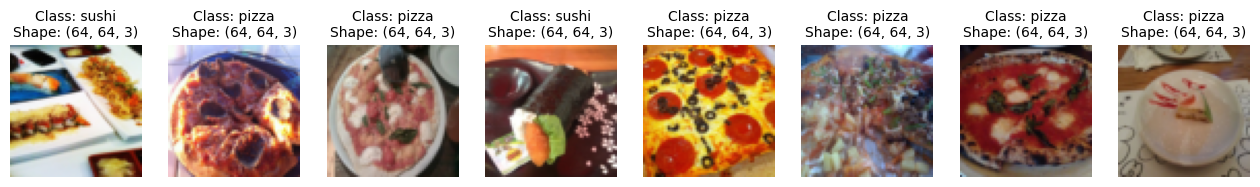

In [45]:
dataloaders.display_random_images(n=8)

In [55]:
class_names = dataloaders.classes
class_names

['pizza', 'steak', 'sushi']

## Model Builder

In [47]:
%%writefile ../src/model_builder.py
"""
Contains PyTorch model code to instantiate a TinyVGG model.
"""
import torch

from torch import nn

class TinyVGG(nn.Module):
    """Creates the TinyVGG architecture.

    Replicates the TinyVGG architecture from the CNN explainer website in PyTorch.
    See the original architecture here: https://poloclub.github.io/cnn-explainer/

    Args:
    input_shape: An integer indicating number of input channels.
    hidden_units: An integer indicating number of hidden units between layers.
    output_shape: An integer indicating number of output units.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape, 
                    out_channels=hidden_units, 
                    kernel_size=3, 
                    stride=1, 
                    padding=0),  
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units, 
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                        stride=2)
        )
        self.conv_block_2 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
          nn.Flatten(),
          # Where did this in_features shape come from? 
          # It's because each layer of our network compresses and changes the shape of our inputs data.
          nn.Linear(in_features=hidden_units*13*13,
                    out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x
        # return self.classifier(self.block_2(self.block_1(x))) # <- leverage the benefits of operator fusion

Writing ../src/model_builder.py


In [56]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(".."))

# Now import model_builder
from src import model_builder

device = "cuda" if torch.cuda.is_available() else "cpu"

# Instantiate an instance of the model from the "model_builder.py" script
torch.manual_seed(42)
model_1 = model_builder.TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                                hidden_units=10, 
                                output_shape=len(class_names)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

## Training Engine

In [7]:
%%writefile ../src/engine.py
import torch
import torch.nn as nn
import torchmetrics
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def train_step(model: nn.Module,
               dataloader: DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               acc_fn: torchmetrics.Metric = None,
               device: str = "cpu"):
    """Performs one training step for a given model."""
    model.train()
    train_loss, train_acc = 0, 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)

        # Compute loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Compute accuracy
        y_pred_probs = torch.softmax(y_pred, dim=1)
        y_pred_labels = torch.argmax(y_pred_probs, dim=1)
        acc = (y_pred_labels == y).float().mean().item()

        train_acc += acc

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return train_loss / len(dataloader), train_acc / len(dataloader)


def test_step(model: nn.Module,
              dataloader: DataLoader,
              loss_fn: nn.Module,
              acc_fn: torchmetrics.Metric = None,
              device: str = "cpu"):
    """Performs one testing step for a given model."""
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_pred = model(X)

            # Compute loss
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            # Compute accuracy
            y_pred_probs = torch.softmax(y_pred, dim=1)
            y_pred_labels = torch.argmax(y_pred_probs, dim=1)
            acc = (y_pred_labels == y).float().mean().item()

            test_acc += acc

    return test_loss / len(dataloader), test_acc / len(dataloader)


def train(model: nn.Module,
          train_dataloader: DataLoader,
          test_dataloader: DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: nn.Module = nn.CrossEntropyLoss(),
          acc_fn: torchmetrics.Metric = None,
          epochs: int = 5,
          device: str = "cpu",
          log_interval: int = 1):
    """
    Trains and evaluates a given model.

    Parameters
    ----------
    model : nn.Module
        The neural network model to train.
    train_dataloader : DataLoader
        The DataLoader providing batches of training data.
    test_dataloader : DataLoader
        The DataLoader providing batches of testing data.
    optimizer : torch.optim.Optimizer
        The optimizer for updating model weights.
    loss_fn : nn.Module, optional
        The loss function (default is CrossEntropyLoss).
    acc_fn : torchmetrics.Metric, optional
        The accuracy metric function.
    epochs : int, optional
        The number of epochs to train (default is 5).
    device : str, optional
        The device to run computations on ("cpu" or "cuda", default is "cpu").
    log_interval : int, optional
        Logging interval (1 = every epoch, 5 = 1st, 5th, 10th, etc., 0 = no logs).

    Returns
    -------
    dict
        Dictionary containing training and testing loss/accuracy values.
    """
    model.to(device)
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in range(epochs):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, acc_fn, device)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, acc_fn, device)

        # Store results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # Log based on log_interval
        if log_interval > 0 and (epoch == 0 or (epoch + 1) % log_interval == 0):
            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                  f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    return results

def plot_loss_curves(results):
    """Plots training curves of a results dictionary.
    
    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']
    
    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']
    
    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))
    
    # Setup a plot 
    plt.figure(figsize=(15, 7))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

    plt.show()

Overwriting ../src/engine.py


## Save model

In [59]:
%%writefile ../src/utils.py
"""
Contains various utility functions for PyTorch model training and saving.
"""
from pathlib import Path

import torch

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    """Saves a PyTorch model to a target directory.

    Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

    Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

Writing ../src/utils.py


## Train step

In [1]:
%%writefile ../src/train.py
"""
Trains a PyTorch image classification model using device-agnostic code.
"""
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(".."))
import os
import torch
from torchvision import transforms
from src import data_setup, engine, model_builder, utils


# Setup hyperparameters
NUM_EPOCHS = 5
BATCH_SIZE = 32
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001

# Setup directories
train_dir = "./inputs/pizza_steak_sushi/train"
test_dir = "./inputs/pizza_steak_sushi/test"

# Setup target device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create transforms
data_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create DataLoaders with help from data_setup.py
dataloader = data_setup.CustomDataloader(train_dir=train_dir, test_dir=test_dir,
                                         transform=data_transform, batch_size=BATCH_SIZE, transform_test_data=False)
train_dataloader, test_dataloader = dataloader.get_dataloaders()
class_names = dataloader.classes

# dataloader, class_names

# Create model with help from model_builder.py
model = model_builder.TinyVGG(
    input_shape=3,
    hidden_units=HIDDEN_UNITS,
    output_shape=len(class_names)
).to(device)

# # Set loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# # Start training with help from engine.py
results=engine.train(model=model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=NUM_EPOCHS,
             device=device, log_interval=1)
engine.plot_loss_curves(results)

Overwriting ../src/train.py
